In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### 1. 데이터 클렌징 및 가공

In [2]:
bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


- datetime - hourly date + timestamp    
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter   
- holiday - whether the day is considered a holiday  
- workingday - whether the day is neither a weekend nor holiday  
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
             - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
             - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
             - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
- temp - temperature in Celsius  
- atemp - "feels like" temperature in Celsius  
- humidity - relative humidity  
- windspeed - wind speed  
- casual - number of non-registered user rentals initiated  
- registered - number of registered user rentals initiated  
- count - number of total rentals  

In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- null 데이터 없음
- datetime object -> 여러개 속성 분리 필요

In [4]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2


In [5]:
# 피처 정리 (casual+registerd = count이며 다중공선성 문제 해결 위해 삭제)
drop_columns = ['datetime', 'casual', 'registered']   
bike_df.drop(drop_columns, axis=1, inplace=True)

#### 성능평가함수 구현

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#log값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) **2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)    # MAE는 mean_absolute_error()로 계산
    print('RMSlE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

### 2. 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_trian, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state=1)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_trian)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSlE: 1.146, RMSE: 142.656, MAE: 106.554


#### - 실제 값과 예측값이 어느정도 차이가 나는지 확인

In [8]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 실제 값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test, pred, n_tops = 5)

      real_count  predicted_count   diff
1950         809            194.0  615.0
1451         948            360.0  588.0
76           917            339.0  578.0
555          677            116.0  561.0
1302         970            410.0  560.0


- 차이가 550 내외로 굉장히 크게 나타남
- Target의 분포 형태의 왜곡성 확인 필요

<AxesSubplot:>

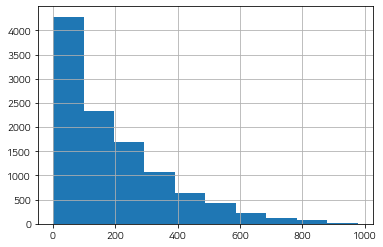

In [9]:
y_target.hist()

- 정규분포가 아님 0 ~ 200 사이에 왜곡
- log1p()를 이용하여 변환

<AxesSubplot:>

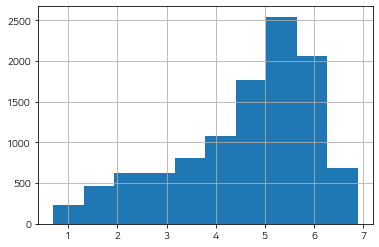

In [10]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

- 왜곡이 조금 향상된 타겟으로 다시 학습/평가 진행

In [11]:
# count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 변환 데이터로 다시 데이터 세트 분할
X_train, X_test, y_trian, y_test = train_test_split(X_features, y_target_log, test_size = 0.3, random_state=1)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_trian)
pred = lr_reg.predict(X_test)

# target 원래 스케일 변환
y_test_exp = np.expm1(y_test)

# 예측값 원래 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSlE: 1.011, RMSE: 163.752, MAE: 110.319


- RMSLE은 줄었지만 RMSE는 더 늘어남
- 피처의 회귀 계수값 시각화

<AxesSubplot:>

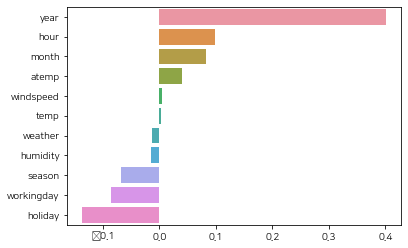

In [12]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- year 숫자형 값에 크게 영향을 받으므로 원-핫 인코딩 적용 변환

In [13]:
# 'year', 'month', 'day', 'hour' 피저 원-핫 인코딩
ohe_columns = ['year', 'month', 'hour', 'holiday', 'workingday', 'season', 'weather']
X_features_ohe = pd.get_dummies(X_features, columns=ohe_columns)
X_features_ohe.head()

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [14]:
# 원-핫 인코딩 데이터로 다시 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state=1)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model,X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test_exp, pred)

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_trian, y_test, is_expm1=True)

### LinearRegression ###
RMSlE: 0.584, RMSE: 95.811, MAE: 62.806
### Ridge ###
RMSlE: 0.586, RMSE: 96.847, MAE: 63.524
### Lasso ###
RMSlE: 0.636, RMSE: 112.616, MAE: 72.970


<AxesSubplot:>

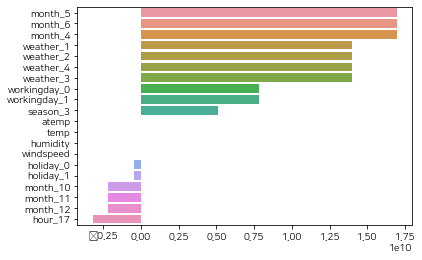

In [15]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### 3. 회귀 트리를 이용한 회귀 예측

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train.values, X_test.values, y_trian.values, y_test.values, is_expm1=True)
    # XGBoost는 DF인 경우 버전에 따라 오류 발생 > ndarray로 변환

### RandomForestRegressor ###
RMSlE: 0.347, RMSE: 48.226, MAE: 30.400
### GradientBoostingRegressor ###
RMSlE: 0.335, RMSE: 52.964, MAE: 33.779
### XGBRegressor ###
RMSlE: 0.349, RMSE: 49.941, MAE: 31.688
### LGBMRegressor ###
RMSlE: 0.318, RMSE: 45.093, MAE: 28.187


### csv submit 저장

In [17]:
test_df = pd.read_csv('./bike_test.csv')

# 문자열을 datetime 타입으로 변경
test_df['datetime'] = test_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
test_df['year'] = test_df.datetime.apply(lambda x : x.year)
test_df['month'] = test_df.datetime.apply(lambda x : x.month)
test_df['hour'] = test_df.datetime.apply(lambda x : x.hour)

In [18]:
drop_columns = ['datetime']   
test = test_df.drop(drop_columns, axis=1, inplace=False)

In [19]:
ohe_columns = ['year', 'month', 'hour', 'holiday', 'workingday', 'season', 'weather']
test_ohe = pd.get_dummies(test, columns=ohe_columns)
test_ohe.head()

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,10.66,11.365,56,26.0027,1,0,1,0,0,0,...,0,1,1,0,0,0,1,0,0,0
1,10.66,13.635,56,0.0000,1,0,1,0,0,0,...,0,1,1,0,0,0,1,0,0,0
2,10.66,13.635,56,0.0000,1,0,1,0,0,0,...,0,1,1,0,0,0,1,0,0,0
3,10.66,12.880,56,11.0014,1,0,1,0,0,0,...,0,1,1,0,0,0,1,0,0,0
4,10.66,12.880,56,11.0014,1,0,1,0,0,0,...,0,1,1,0,0,0,1,0,0,0


In [27]:
pred = lgbm_reg.predict(test_ohe)

In [39]:
pd.DataFrame({'datetime' : test_df['datetime'], 'count' : pred}).set_index('datetime').to_csv('submission.csv')